**1. Install Required Packages**

In [1]:
# Install required packages
!pip install -q kaggle tensorflow

**2. Upload Kaggle API Token**

In [2]:
# Upload your kaggle.json file
from google.colab import files
print("Please upload your kaggle.json file:")
files.upload()

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sharaffgan","key":"b8444d9a23de205d31200f4f1758edc6"}'}

**3. Setup Kaggle API**

In [3]:
# Configure Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

**4. Download Dataset**

In [4]:
# Download dataset from Kaggle
DATASET_URL = "borhanitrash/animal-image-classification-dataset"
!kaggle datasets download -d {DATASET_URL}

Dataset URL: https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset
License(s): MIT
 81% 31.0M/38.4M [00:00<00:00, 113MB/s] 
100% 38.4M/38.4M [00:00<00:00, 114MB/s]


**5. Prepare Dataset Directory**

In [5]:
# Clean and setup directory structure
!rm -rf animals_dataset  # Remove if exists
!mkdir animals_dataset

# Unzip dataset (force overwrite)
!unzip -q -o animal-image-classification-dataset.zip -d animals_dataset

**6. Find Dataset Path**

In [6]:
# Automatically locate the image directory
import os
base_dir = None
for root, dirs, files in os.walk("animals_dataset"):
    if dirs and not files:  # Directory with subfolders
        base_dir = root
        break
    elif any(f.endswith(('.jpg', '.png', '.jpeg')) for f in files):
        base_dir = root
        break

if base_dir is None:
    raise FileNotFoundError("Could not find directory with image files")

print(f"Found dataset directory: {base_dir}")

Found dataset directory: animals_dataset/Animals


**7. Setup Data Generators**

In [7]:
# Configure image data generators
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


**8. Build Model Architecture**

In [8]:
# Create MobileNetV2 model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

base_model = MobileNetV2(input_shape=(224, 224, 3),
                        include_top=False,
                        weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**9. Initial Training**

In [9]:
# First training phase (feature extraction)
initial_epochs = 10
history = model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.8018 - loss: 0.4798

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 53s 551ms/step - accuracy: 0.8031 - loss: 0.4770 - val_accuracy: 0.9750 - val_loss: 0.1083
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - accuracy: 0.9617 - loss: 0.1062 - val_accuracy: 0.9800 - val_loss: 0.0716
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 438ms/step - accuracy: 0.9759 - loss: 0.0801 - val_accuracy: 0.9733 - val_loss: 0.0832
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 480ms/step - accuracy: 0.9852 - loss: 0.0580 - val_accuracy: 0.9750 - val_loss: 0.0709
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 458ms/step - accuracy: 0.9865 - loss: 0.0462 - val_accuracy: 0.9800 - val_loss: 0.0755
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 458ms/step - accuracy: 0.9838 - loss: 0.0496 - val_accuracy: 0.9683 - val_loss: 0.0800
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 459ms/step - accuracy: 0.9819 - loss: 0.0527 - val_accuracy: 0.9767 - val_loss: 0.0554
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 438ms/step - accuracy: 0.9890 - loss: 0.0342 - val_accuracy: 0.976

**10. Fine-Tuning**

In [10]:
# Second training phase (fine-tuning)
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_generator
)

Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 90s 545ms/step - accuracy: 0.8366 - loss: 0.4842 - val_accuracy: 0.9750 - val_loss: 0.1089
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 474ms/step - accuracy: 0.9586 - loss: 0.1094 - val_accuracy: 0.9750 - val_loss: 0.1049
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 473ms/step - accuracy: 0.9748 - loss: 0.0643 - val_accuracy: 0.9683 - val_loss: 0.1183
Epoch 13/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 476ms/step - accuracy: 0.9825 - loss: 0.0604 - val_accuracy: 0.9733 - val_loss: 0.1115
Epoch 14/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 478ms/step - accuracy: 0.9783 - loss: 0.0578 - val_accuracy: 0.9733 - val_loss: 0.0980
Epoch 15/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 477ms/step - accuracy: 0.9849 - loss: 0.0446 - val_accuracy: 0.9750 - val_loss: 0.0949
Epoch 16/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 479ms/step - accuracy: 0.9789 - loss: 0.0581 - val_accuracy: 0.9767 - val_loss: 0.0783
Epoch 17/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 522ms/step - accuracy: 0.9920 - loss: 0.0283 - 

**11. Visualize Results**

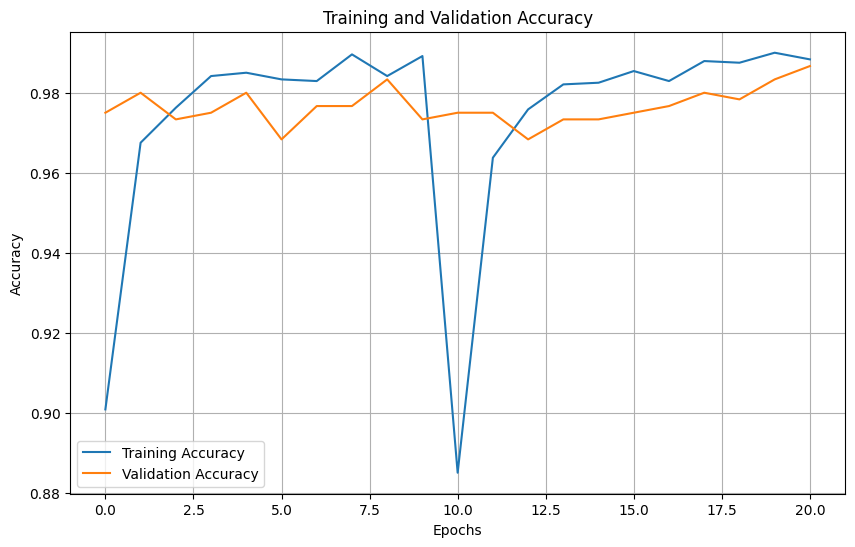

In [11]:
# Plot training history
import matplotlib.pyplot as plt

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Accuracy')
plt.show()